# SLA1 Camera Characterization

## PSF Candidates in 30s Darks

On May 8, 2024 (UTC) we took various dark exposures with the [QHY42 Pro](https://www.qhyccd.com/qhy42pro/) camera.

As they are read in, the darks are scaled to undo zero padding (divided by 16) and the effect of gain (multiplied by 1.39).

They are then combined into a master dark. The master dark is subtracted from the individual darks.

Then we find pixels that (a) exceed a threshold and (b) are brighter than their
four nearest neighbors. These are the &ldquo;hot pixel leaders.&rdquo

Then we cull the hot pixel leaders whose neighbors fall off too sharply
using the following quick criterion for non-PSF-shaped regions: any hot pixel leader that has a neighbor <30% of the peak is not a PSF candidate.

Finally, the region around these candidates is displayed.

### Notes

The pixels are 1.5x1.5 arcsec. In seeing of FWHM=3 arcsec, the PSF will have a FWHM=2 pixels.

A better criterion to consider implementing later:

Compute the probability that the  5x5 pixels (with >200 e-) could have been drawn from the PSF shape plus Poisson noise. Essentially chi-squared. Normalize perhaps by the peak value set to 1.0, or normalized by total area.


In [1]:
# THIS COMMENT IS THE LONGEST A LINE CAN BE AND STILL RENDER COMPLETELY WHEN PRINTING IN LANDSCAPE MODE.

import os, sys
import numpy as np
from astropy import units as u
from astropy.nddata import CCDData
from astropy.io import fits
from ccdproc import ImageFileCollection, combine, subtract_dark, flat_correct # Combiner
import astroalign as aa
import matplotlib.pyplot as plt
%matplotlib inline
from math import log10, floor

home_directory = os.path.expanduser('~')

# soft link to directory containing raw images
sessions_directory = os.path.join(home_directory, '2024 SLA Sessions')

uv_project_directory = os.path.join(home_directory, 'Projects', 'uv-transients')
analysis_directory = os.path.join(uv_project_directory, 'analyses', '30s_darks')

# The path to the first dark on SLA1 is D:/Raw/2024-05-08/03_38_48/Dark30s/00001.fits
# The files to be processed need to be mirrored on the local machine
# at ~/2024 SLA Sessions/ using the same subdirectory structure.
capture_date = '2024-05-08'
capture_time = '03_38_48'
object_name = 'Dark30s'

# Amount to scale the image data (typically to undo 0 padding of 12-bit to 16-bit values)

scale_due_to_padding = 2**4  # This is division by 16

scale_due_to_gain = 1.39  # from QHYCCD manual for gain of 5

scale = scale_due_to_gain / scale_due_to_padding

# threshold for flagging hot pixels

threshold = 200

# discontinuity limit

ratio = 0.2

# subdirectory for the 30-second darks (following SharpCap Pro capture directory conventions)
dark_directory = os.path.join(
    sessions_directory,
    capture_date,
    capture_time,
    object_name
)

# exposure duration

dark_exposure = 30.0
dark_exposure_with_ccdproc_units = dark_exposure * u.second

# FITS header confirmation

def confirm_fits_header(image, dimensions, exposure_time, filter):
    header = image.header
    assert header['NAXIS1'] == dimensions[0]
    assert header['NAXIS2'] == dimensions[1]
    assert header['EXPTIME'] == exposure_time
    if filter:
        assert header['FILTER'].rstrip() == filter
        
# Reader with optional parameter to scale (divide) the ADU readings

def scaled_image_reader(file, scale=1):
    img = CCDData.read(file, unit=u.adu)
    scaled_data = img.data * scale
    img.data = scaled_data
    return img

# After all the preliminaries, we read in and combine the dark files

dark_files = ImageFileCollection(dark_directory).files_filtered(include_path='True')

darks = [scaled_image_reader(file, scale=scale) for file in dark_files]

for dark in darks:
    confirm_fits_header(dark, (2048, 2048), dark_exposure, None)

combination_method = 'median'  # alternatively, the method can be 'average'

master_dark = combine(darks, method=combination_method)


Set MJD-END to 60438.151953 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60438.151953 from DATE-END'.
Set MJD-END to 60438.152301 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60438.152301 from DATE-END'.
Set MJD-END to 60438.152648 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60438.152648 from DATE-END'.
Set MJD-END to 60438.152995 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60438.152995 from DATE-END'.
Set MJD-END to 60438.153342 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60438.153342 from DATE-END'.
Set MJD-END to 60438.153689 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60438.153689 from DATE-END'.
Set MJD-END to 60438.154037 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60438.154037 from DATE-END'.
Set MJD-END to 60438.154384 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60438.154384 from DATE-END'.
Set MJD-END to 60438.154731 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60438.154731 from DATE-END'.
Set MJD-END to 60438.155078 from DATE-END'. [a

## Subtract Master Dark from Darks

In [2]:
subtracted_darks = [
    subtract_dark(
        dark,
        master_dark,
        data_exposure=dark_exposure_with_ccdproc_units,
        dark_exposure=dark_exposure_with_ccdproc_units,
        scale=False
    )
    for dark in darks
]


## The Routines for Locating Hot Pixel Leaders

As a first cut, we will search for all pixels that exceed some threshold. These are the &ldquo;hot pixels.&rdquo;

Then each hot pixel is examined to see if it is the brightest relative to its eight nearest neighbors. If it is, it is added to the list of leaders. (A small bit of tie-breaking code is incorporated.)

In [3]:
from collections import namedtuple

Pixel = namedtuple('Pixel', 'x y value')
PSFCandidate = namedtuple('PSFCandidate', 'center neighbors')

def is_winner_or_tied(candidate_leader, i, j, data):
    return candidate_leader.value >= data[j, i]

def is_leader(candidate_leader, data):
    data_height, data_width = data.shape
    for offset_y, offset_x in [(-1, 0), (0, 1), (1, 0), (0, -1)]:
        j = floor(candidate_leader.y + offset_y)
        i = floor(candidate_leader.x + offset_x)
        if j < 0 or j >= data_height or i < 0 or i >= data_width:
            continue
        if not is_winner_or_tied(candidate_leader, i, j, data):
            return False
    return True

def find_hot_pixel_leaders(data, threshold):
    # first we simply find all the hot pixels
    data_height, data_width = data.shape
    exceedances = data > threshold  # an array of true-false values
    values_of_exceedances = data[exceedances]
    exceedance_indices = np.nonzero(exceedances)  # a crafty way of getting the indices of the exceedances
    # all of the hot pixels are candidate leaders
    candidate_leaders = np.transpose([exceedance_indices[1], exceedance_indices[0], values_of_exceedances])
    leaders = []
    for i in range(candidate_leaders.shape[0]):
        row = candidate_leaders[i]
        candidate_leader = Pixel(row[0], row[1], row[2])
        if is_leader(candidate_leader, data):
            leaders.append(candidate_leader)
    return leaders


## Find the Hot Pixel Leaders

Now we classify all the pixels whose values exceed the threshold as hot pixels. From among these, only the ones
which are brighter than their four nearest neighbors are declared to be &ldquo;leaders.&rdquo;


In [4]:
# there will be a list of leaders for each dark

hot_pixel_leaders_for_darks = [
    find_hot_pixel_leaders(subtracted_dark.data, threshold) for subtracted_dark in subtracted_darks
]


## The Routines for Finding PSF Candidates


In [5]:
def is_too_discontinuous(candidate_psf, i, j, data, ratio):
    return data[j, i] < ratio * candidate_psf.value 

def is_candidate_psf(candidate_psf, data, ratio):
    data_height, data_width = data.shape
    for offset_y, offset_x in [(-1, 0), (0, 1), (1, 0), (0, -1)]:
        j = floor(candidate_psf.y + offset_y)
        i = floor(candidate_psf.x + offset_x)
        if j < 0 or j >= data_height or i < 0 or i >= data_width:
            continue
        if is_too_discontinuous(candidate_psf, i, j, data, ratio):
            return False
    return True

def find_psf_candidates(leaders, data, ratio):
    candidates = [leader for leader in leaders if is_candidate_psf(leader, data, ratio)]
    return candidates


## Find the PSF Candidates

In [6]:
candidates_for_darks = [
    find_psf_candidates(hot_pixel_leaders, subtracted_darks[k].data, ratio)
    for k, hot_pixel_leaders in enumerate(hot_pixel_leaders_for_darks)
]


## Display the Candidates

Displaying candidates for dark /Users/brian/2024 SLA Sessions/2024-05-08/03_38_48/Dark30s/00001.fits
Displaying candidates for dark /Users/brian/2024 SLA Sessions/2024-05-08/03_38_48/Dark30s/00002.fits
Displaying candidates for dark /Users/brian/2024 SLA Sessions/2024-05-08/03_38_48/Dark30s/00003.fits
Displaying candidates for dark /Users/brian/2024 SLA Sessions/2024-05-08/03_38_48/Dark30s/00004.fits
Pixel(x=1533.0, y=1104.0, value=403.3606249999999) is a PSF candidate with neighbor values:
    x=1533, y=1103, value=114.11031250000008
    x=1534, y=1104, value=165.6271875
    x=1533, y=1105, value=172.01250000000005
    x=1532, y=1104, value=231.91281249999997


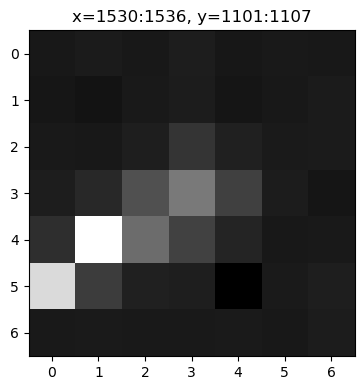

Displaying candidates for dark /Users/brian/2024 SLA Sessions/2024-05-08/03_38_48/Dark30s/00005.fits
Displaying candidates for dark /Users/brian/2024 SLA Sessions/2024-05-08/03_38_48/Dark30s/00006.fits
Displaying candidates for dark /Users/brian/2024 SLA Sessions/2024-05-08/03_38_48/Dark30s/00007.fits
Displaying candidates for dark /Users/brian/2024 SLA Sessions/2024-05-08/03_38_48/Dark30s/00008.fits
Displaying candidates for dark /Users/brian/2024 SLA Sessions/2024-05-08/03_38_48/Dark30s/00009.fits
Displaying candidates for dark /Users/brian/2024 SLA Sessions/2024-05-08/03_38_48/Dark30s/00010.fits


In [7]:
DISPLAY_HALF_RANGE = 3
DISPLAY_FULL_RANGE = 2 * DISPLAY_HALF_RANGE + 1

def display_candidate(candidate, data):
    
    data_height, data_width = data.shape

    lower_x = floor(candidate.x - DISPLAY_HALF_RANGE)
    upper_x = floor(lower_x + DISPLAY_FULL_RANGE)
    slice_x = slice(lower_x, upper_x)
    lower_y = floor(candidate.y - DISPLAY_HALF_RANGE)
    upper_y = floor(lower_y + DISPLAY_FULL_RANGE)
    slice_y = slice(lower_y, upper_y)
    
    fig_size_x = 4
    fig_size_y = 4
    
    # a bit of fussy code for dealing with display near the edges
    
    if (lower_x < 0):
        lower_x = 0
        fig_size_x *= upper_x / 5
    elif (upper_x > data_width):
        upper_x = data_width
        fig_size_x *= (data_width - lower_x) / DISPLAY_FULL_RANGE

        
    if (lower_y < 0):
        lower_y = 0
        fig_size_y *= upper_y / 5
    elif (upper_y > data_height):
        upper_y = data_height
        fig_size_y *= (data_height - lower_y) / DISPLAY_FULL_RANGE

    fig, axes = plt.subplots(1, 1, figsize=(fig_size_x, fig_size_y))
    
    print("{} is a PSF candidate with neighbor values:".format(candidate))
    
    for offset_y, offset_x in [(-1, 0), (0, 1), (1, 0), (0, -1)]:
        j = floor(candidate.y + offset_y)
        i = floor(candidate.x + offset_x)
        if j < 0 or j >= data_height or i < 0 or i >= data_width:
            continue
        print("    x={}, y={}, value={}".format(i, j, data[j][i]))
    
    title = "x={}:{}, y={}:{}".format(lower_x, upper_x - 1, lower_y, upper_y - 1)
    
    subframe = data[lower_y:upper_y, lower_x:upper_x]
    
    axes.imshow(subframe, cmap='gray')
    axes.set_title(title, fontsize=12)
    plt.tight_layout()
    plt.show()

for k in range(len(candidates_for_darks)):
    candidates = candidates_for_darks[k]
    subtracted_dark_data = subtracted_darks[k].data
    print('Displaying candidates for dark {}'.format(dark_files[k]))

    for candidate in candidates:
        display_candidate(candidate, subtracted_dark_data)
